# Linear Quadratic Regulator

In [1]:
import gym
import tensorflow as tf
import numpy as np
import pickle
import control

In [2]:
model = tf.keras.models.load_model(
    './cartpole_system_model', custom_objects=None, compile=True, options=None
)
np_weights = model.get_weights()

A = np_weights[0]
B = np_weights[1].T
print("A Matrix")
print(A)
print("B Matrix")
print(B)

A Matrix
[[-1.5739264e-08 -3.6348650e-04 -1.6419442e-08  1.4684309e-03]
 [ 1.9999964e-02  1.8883319e-04 -1.0376565e-08 -1.3297781e-03]
 [-6.3428889e-09 -1.3173890e-02  1.2812671e-08  3.1240752e-01]
 [ 2.3316607e-08  1.7133448e-04  2.0000000e-02 -5.5705023e-04]]
B Matrix
[[-1.7497801e-08]
 [ 1.9511257e-01]
 [-6.7852040e-09]
 [-2.9143080e-01]]


2022-04-27 01:25:50.432471: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def cartpole_simulation(K):
    env = gym.make('CartPole-v1')
    x = env.reset()
    cumul_reward = 0
    for _ in range(500):
        u = np.matmul(-K, x)
        if u < 0:
            u = 0
        else:
            u = 1
        x, reward, done, _ = env.step(u)
        cumul_reward += reward
        if done:
            break
    env.close()
    return cumul_reward

## Continuous Algebraic Ricatti Equation

We define a cost function for observation/state spaces $x$ and control inputs $u$.

$x^T Qx + u^T Ru$,

with $Q$ as the state space weight and $R$ as the control input space weight.

Infinite-horizon continuous algebraic Ricatti equation (CARE):

$Q - S(t)B R^{-1} B^T S(t) + S(t)A + A^T S(t) = 0$

The K gain can be derived as

$K = R^{-1} B^T S(t)$, 

which can be used for the control input $u = -Kx$.

In [8]:
Q = np.diag([1, 1, 10, 100])

# R (control input gain) is set as the identity matrix
S, Lambda_S, K_gain = control.care(A, B, Q, R=None)

print("Solution")
print(S, "\n")

print("Eigenvalues")
print(Lambda_S, "\n")

print("K (Gain)")
print(K_gain, "\n")

Solution
[[ 1.82223842e+04 -2.48925045e+01 -9.54271217e+01 -1.64570727e+01]
 [-2.48925045e+01  2.70814641e+02  2.66772666e+01  1.83688452e+02]
 [-9.54271217e+01  2.66772666e+01  1.06394557e+02  2.93301405e+01]
 [-1.64570727e+01  1.83688452e+02  2.93301405e+01  1.60191604e+02]] 

Eigenvalues
[-2.92126289e+00+0.j         -9.97788379e-02+0.j
 -2.30430563e-03+0.00088374j -2.30430563e-03-0.00088374j] 

K (Gain)
[[ -0.06106089  -0.69313154  -3.34263532 -10.84484125]] 



In [5]:
cartpole_simulation(K_gain)

500.0

It seems that despite the aforementioned indication of a continuous control system, DARE performs much better.

In [9]:
save_care_controller_dict = {"K": K_gain, "S": S, "A": A, "B": B}
print(save_care_controller_dict)
with open('./cartpole_system_model/care_controller.pkl', 'wb') as filepath:
    pickle.dump(save_care_controller_dict, filepath, protocol=pickle.HIGHEST_PROTOCOL)

{'K': array([[ -0.06106089,  -0.69313154,  -3.34263532, -10.84484125]]), 'S': array([[ 1.82223842e+04, -2.48925045e+01, -9.54271217e+01,
        -1.64570727e+01],
       [-2.48925045e+01,  2.70814641e+02,  2.66772666e+01,
         1.83688452e+02],
       [-9.54271217e+01,  2.66772666e+01,  1.06394557e+02,
         2.93301405e+01],
       [-1.64570727e+01,  1.83688452e+02,  2.93301405e+01,
         1.60191604e+02]]), 'A': array([[-1.5739264e-08, -3.6348650e-04, -1.6419442e-08,  1.4684309e-03],
       [ 1.9999964e-02,  1.8883319e-04, -1.0376565e-08, -1.3297781e-03],
       [-6.3428889e-09, -1.3173890e-02,  1.2812671e-08,  3.1240752e-01],
       [ 2.3316607e-08,  1.7133448e-04,  2.0000000e-02, -5.5705023e-04]],
      dtype=float32), 'B': array([[-1.7497801e-08],
       [ 1.9511257e-01],
       [-6.7852040e-09],
       [-2.9143080e-01]], dtype=float32)}


## Optimizing Q for CARE

In [10]:
import cma

In [11]:
# A and B are global variables
def cartpole_loss(q_diag):
    Q = np.diag(q_diag)
    _, _, K = control.dare(A, B, Q, R=None)
    
    # cartpole simulation
    env = gym.make('CartPole-v1')
    x = env.reset()
    cumul_loss = 500
    for _ in range(500):
        u = np.matmul(-K, x)
        if u < 0:
            u = 0
        else:
            u = 1
        x, reward, done, _ = env.step(u)
        cumul_loss -= reward
        if done:
            break
    env.close()
    return cumul_loss

In [12]:
es = cma.CMAEvolutionStrategy((1, 1, 10, 100), 1.0)
with open('./cartpole_system_model/cma_es_history_Q.pkl', 'wb') as filepath:
    pickle.dump(es, filepath)

while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [cartpole_loss(x) for x in solutions])
    es.logger.add()  # write data to disc to be plotted
    es.disp()
with open('./cartpole_system_model/cma_es_history_Q.pkl', 'wb') as filepath:
    pickle.dump(es, filepath)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=1101981, Wed Apr 27 01:27:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.730000000000000e+02 1.0e+00 9.46e-01  7e-01  1e+00 0:00.0
    2     16 4.770000000000000e+02 1.5e+00 8.71e-01  6e-01  1e+00 0:00.1
    3     24 4.730000000000000e+02 1.8e+00 8.60e-01  6e-01  1e+00 0:00.1
  100    800 4.730000000000000e+02 1.7e+01 1.04e+00  1e-01  8e-01 0:01.7
  200   1600 4.730000000000000e+02 5.4e+01 6.54e-01  2e-02  1e-01 0:03.4
  300   2400 4.730000000000000e+02 8.1e+02 1.21e+00  2e-02  2e-01 0:05.0
  400   3200 4.720000000000000e+02 2.1e+03 1.15e+00  1e-02  9e-02 0:06.7
  500   4000 4.720000000000000e+02 4.4e+03 8.22e-01  4e-03  1e-02 0:08.2
  505   4040 4.730000000000000e+02 4.6e+03 1.26e+00  5e-03  2e-02 0:08.3


termination on tolstagnation=198
final/bestever f-value = 4.730000e+02 4.720000e+02
incumbent solution: [-8.554020517342108, 9.775567091016356, 16.864374503495718, 100.22872195524612]
std deviation: [0.018352838315088976, 0.011987899898183805, 0.012625744384984882, 0.005455566939373828]


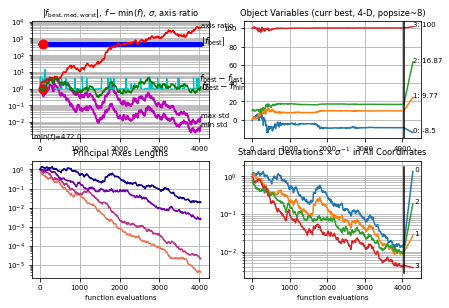

In [13]:
with open('./cartpole_system_model/cma_es_history_Q.pkl', 'rb') as filepath:
    es = pickle.load(filepath)
es.result_pretty()
cma.plot()

In [14]:
print(es.result.xbest)
print(es.result.fbest)

[  2.40373728   1.29433435   9.84547941 100.7513878 ]
472.0


In [15]:
Q = np.diag(es.result.xbest)

In [16]:
# R (control input gain) is set as the identity matrix
S, Lambda_S, K_gain = control.care(A, B, Q, R=None)

print("Solution")
print(S, "\n")

print("Eigenvalues")
print(Lambda_S, "\n")

print("K (Gain)")
print(K_gain, "\n")

Solution
[[20811.76752554   -60.01452612  -113.06004796   -40.3526376 ]
 [  -60.01452612   302.61789143    32.00933068   205.43036241]
 [ -113.06004796    32.00933068   106.87251809    32.89380475]
 [  -40.3526376    205.43036241    32.89380475   175.19335438]] 

Eigenvalues
[-2.93411475e+00 -1.87472859e-03 -3.34728371e-03 -9.85872732e-02] 

K (Gain)
[[  0.05004961  -0.8241794   -3.34084381 -10.97469295]] 



In [17]:
cartpole_simulation(K_gain)

500.0

In [18]:
save_care_controller_dict = {"K": K_gain, "S": S, "A": A, "B": B}
print(save_care_controller_dict)
with open('./cartpole_system_model/best_care_controller.pkl', 'wb') as filepath:
    pickle.dump(save_care_controller_dict, filepath, protocol=pickle.HIGHEST_PROTOCOL)

{'K': array([[  0.05004961,  -0.8241794 ,  -3.34084381, -10.97469295]]), 'S': array([[20811.76752554,   -60.01452612,  -113.06004796,   -40.3526376 ],
       [  -60.01452612,   302.61789143,    32.00933068,   205.43036241],
       [ -113.06004796,    32.00933068,   106.87251809,    32.89380475],
       [  -40.3526376 ,   205.43036241,    32.89380475,   175.19335438]]), 'A': array([[-1.5739264e-08, -3.6348650e-04, -1.6419442e-08,  1.4684309e-03],
       [ 1.9999964e-02,  1.8883319e-04, -1.0376565e-08, -1.3297781e-03],
       [-6.3428889e-09, -1.3173890e-02,  1.2812671e-08,  3.1240752e-01],
       [ 2.3316607e-08,  1.7133448e-04,  2.0000000e-02, -5.5705023e-04]],
      dtype=float32), 'B': array([[-1.7497801e-08],
       [ 1.9511257e-01],
       [-6.7852040e-09],
       [-2.9143080e-01]], dtype=float32)}
